# Example workflow

To get all the dependencies and workflows right, let's first use a prototype example.

This is thoroughly imitating the workflow [here][1], by Chris, from Kaggle.

It will probably go alright.

[1]: https://www.kaggle.com/center-for-policing-equity/data-science-for-good/discussion/67450

In [1]:
# imports

import fiona
import pandas as pd
import pyproj
from fiona.crs import from_epsg
from shapely.geometry import shape

# constants

wgs84_crs = from_epsg(4326)

# Boston Police Department

The example used Providence, but, we have no data for it. So we focus on Boston instead.

![](https://upload.wikimedia.org/wikipedia/en/b/b7/Boston_Police_patch.jpg)

In [2]:
with fiona.open('../../data/departments/11-00091/external/shapefiles') as c:
    records = list(c)
    schema = c.schema
    crs = c.crs

In [3]:
print(f"There are {len(records)} precincts in the file")

There are 12 precincts in the file


# District D-14 | Brighton

Let's focus on this district, which is the first in the data.

In [4]:
rec = records[0]
rec['properties']

OrderedDict([('DISTRICT_I', 0.0),
             ('ID', 'D14'),
             ('DISTRICT', 'D14'),
             ('SHAPE_area', 123631015.285),
             ('SHAPE_len', 58042.1488028)])

There's very little information here. The **district name**, the area and lenght of the representing Polygon.

In [5]:
rec['geometry']['type']

'Polygon'

In [6]:
# pretty detailed representation

len(rec['geometry']['coordinates'][0])

3731

## Normalizing the coordinates

First we will normalize the CRS (Coordinate Reference System). We want all our spatial data to follow the [WGS 84][1].

[1]: https://en.wikipedia.org/wiki/World_Geodetic_System

In [7]:
crs  # this references the initial coordinate reference system
     # it uses a Lambert conformal conic project with west-virginia (?)
     # as a reference point

{'init': 'epsg:2249'}

In [8]:
# create pyproj Proj instances to perform the transformation
p1 = pyproj.Proj(crs, preserve_units=True)
p2 = pyproj.Proj(wgs84_crs)

In [9]:
# make the transformation

xs, ys = zip(*rec['geometry']['coordinates'][0])
lons, lats = pyproj.transform(p1, p2, xs, ys)

In [10]:
# save back to rec
# note: we will want work on a copy during the real thing

coords = rec['geometry']['coordinates']
coords[0] = list(zip(lons, lats))

In [11]:
coords[0][:5]

[(-71.11075672247946, 42.352217305345185),
 (-71.11065506712275, 42.352208584761065),
 (-71.11066000100348, 42.35209999989928),
 (-71.11068106051837, 42.35195959782716),
 (-71.1107332629976, 42.35162380344347)]

In [12]:
d14_geometry = rec['geometry']

Okay. According to Google, Boston geog. coordinates are 42.3601° N, 71.0589° W

We are on par with this.

# Census data

Now we need to aggregate this info with the census information. Let's retrieve it and glance.

## Feel the information flow

In [13]:
# these were the descriptions in the root inputs directory

var_descriptions = pd.read_csv(
    '../../data/inputs/cpe-data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_race-sex-age/ACS_15_5YR_DP05_metadata.csv',
    header=None
)
var_descriptions.columns = ['name', 'description']
vd = var_descriptions

In [14]:
vd.head()

,name,description
0,GEO.id,Id
1,GEO.id2,Id2
2,GEO.display-label,Geography
3,HC01_VC03,Estimate; SEX AND AGE - Total population
4,HC02_VC03,Margin of Error; SEX AND AGE - Total population


In [15]:
vd.shape

(339, 2)

In [16]:
values = vd['description'].tolist()
values = set(v.split(';')[1] for v in values[3:])
sorted(values)  # okay, this gonna be hard

[' CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population',
 ' CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female',
 ' CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male',
 ' HISPANIC OR LATINO AND RACE - Total housing units',
 ' HISPANIC OR LATINO AND RACE - Total population',
 ' HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)',
 ' HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Cuban',
 ' HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Mexican',
 ' HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Other Hispanic or Latino',
 ' HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Puerto Rican',
 ' HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino',
 ' HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - American Indian an

## Now the shapefile

In [17]:
with fiona.open('../../data/census/2015/shapefiles/massachusetts') as c:
    records = list(c)
    crs = c.crs
    schema = c.schema
    driver = c.driver

In [18]:
crs

{'init': 'epsg:4269'}

In [19]:
schema

{'properties': OrderedDict([('STATEFP', 'str:2'),
              ('COUNTYFP', 'str:3'),
              ('TRACTCE', 'str:6'),
              ('AFFGEOID', 'str:20'),
              ('GEOID', 'str:11'),
              ('NAME', 'str:100'),
              ('LSAD', 'str:2'),
              ('ALAND', 'int:14'),
              ('AWATER', 'int:14')]),
 'geometry': 'Polygon'}

### Normalizing the coordinates

(almost the same as above, but for all records here -ogr2ogr, come to help?)

In [20]:
# create pyproj Proj instances to perform the transformation
p1 = pyproj.Proj(crs, preserve_units=True)
p2 = pyproj.Proj(wgs84_crs)

for rec in records:
    geometry = rec['geometry']
    gtype = geometry['type']
    coords = geometry['coordinates']
    if gtype == 'Polygon':
        new_coords = []
        for ring in coords:
            xs, ys = zip(*ring)
            lons, lats = pyproj.transform(p1, p2, xs, ys)
            new_ring = list(zip(lons, lats))
            new_coords.append(new_ring)
    elif gtype == 'MultiPolygon':
        new_coords = []
        for polygon in coords:
            new_polygon = []
            for ring in polygon:
                xs, ys = zip(*ring)
                lons, lats = pyproj.transform(p1, p2, xs, ys)
                new_ring = list(zip(lons, lats))
                new_polygon.append(new_ring)
            new_coords.append(new_polygon)
    else:
        raise ValueError
    geometry['coordinates'] = new_coords

In [21]:
acs_entries = records

# Overlapping !

I'm not sure yet, but we might use Shapely to retrieve the overlap between regions.

Between, what does it mean to calculate the area when using geographic coordinates. Does that work?

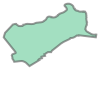

In [22]:
d14_shape = shape(d14_geometry)
d14_shape  # you are freaking kidding me!

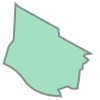

In [23]:
for r in records:
    r['shape'] = shape(r['geometry'])
records[0]['shape']  # lol!

In [24]:
# calculate intersection with D14

for r in records:
    r['intersect'] = r['shape'].intersection(d14_shape).area

In [25]:
relevant = [r for r in records if r['intersect'] > 0]
len(relevant)

30

In [26]:
len(records)

1475

### Good density, that's important

## Merge into the original dataset as percentages

In [27]:
# first we create a dict, (census tract id -> intersection area)

main_dict = {}
for r in records:
    rec_id = r['properties']['AFFGEOID']
    rec_intersection_area = r['intersect']
    main_dict[rec_id] = rec_intersection_area
main_dict

{'1400000US25001013300': 0.0,
 '1400000US25003900300': 0.0,
 '1400000US25003921500': 0.0,
 '1400000US25005610203': 0.0,
 '1400000US25005631600': 0.0,
 '1400000US25005640400': 0.0,
 '1400000US25005641900': 0.0,
 '1400000US25005650300': 0.0,
 '1400000US25005651700': 0.0,
 '1400000US25005652200': 0.0,
 '1400000US25005655100': 0.0,
 '1400000US25005990000': 0.0,
 '1400000US25009205100': 0.0,
 '1400000US25009206000': 0.0,
 '1400000US25009210500': 0.0,
 '1400000US25009217202': 0.0,
 '1400000US25009250500': 0.0,
 '1400000US25009251000': 0.0,
 '1400000US25009253100': 0.0,
 '1400000US25009260600': 0.0,
 '1400000US25009266400': 0.0,
 '1400000US25011041200': 0.0,
 '1400000US25013800201': 0.0,
 '1400000US25013800600': 0.0,
 '1400000US25013801200': 0.0,
 '1400000US25013801603': 0.0,
 '1400000US25013812001': 0.0,
 '1400000US25013812903': 0.0,
 '1400000US25015820700': 0.0,
 '1400000US25015822603': 0.0,
 '1400000US25015822606': 0.0,
 '1400000US25017311800': 0.0,
 '1400000US25017317102': 0.0,
 '1400000U

In [28]:
ser = pd.Series(main_dict)
ser.index.name = 'Id'
ser.name = 'Intersect'

In [29]:
loc = '../../data/departments/11-00091/external/ACS/ACS_15_5YR_DP05_with_ann.csv'
df = pd.read_csv(loc, header=1)
df = df.set_index('Id').join(ser, how='left')
df['Intersect %'] = df['Intersect'] / df['Intersect'].sum()
df.head()

,Id2,Geography,Estimate; SEX AND AGE - Total population,Margin of Error; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population,Percent Margin of Error; SEX AND AGE - Total population,Estimate; SEX AND AGE - Total population - Male,Margin of Error; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Male,Percent Margin of Error; SEX AND AGE - Total population - Male,...,"Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female","Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female","Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",Intersect,Intersect %
Id,,,,,,,,,,,,,,,,,,,,,
1400000US25025000100,25025000100,"Census Tract 1, Suffolk County, Massachusetts",3671,364,3671,(X),1827,289,49.8,4.9,...,1327,292,49.1,6.6,1377,182,50.9,6.6,0.000196,0.156505
1400000US25025000201,25025000201,"Census Tract 2.01, Suffolk County, Massachusetts",3284,325,3284,(X),1494,218,45.5,4.7,...,1250,209,45.8,5.5,1477,208,54.2,5.5,0.000066,0.052633
1400000US25025000202,25025000202,"Census Tract 2.02, Suffolk County, Massachusetts",3587,493,3587,(X),1737,293,48.4,5.2,...,1435,253,49.7,5.4,1451,191,50.3,5.4,0.000066,0.052572
1400000US25025000301,25025000301,"Census Tract 3.01, Suffolk County, Massachusetts",2712,367,2712,(X),1411,339,52.0,7.3,...,1000,269,47.6,8.4,1101,168,52.4,8.4,0.000062,0.049935
1400000US25025000302,25025000302,"Census Tract 3.02, Suffolk County, Massachusetts",2880,353,2880,(X),1182,259,41.0,5.5,...,898,221,40.5,7.0,1320,171,59.5,7.0,0.000070,0.055830


In [30]:
# Finding amount of black people

df = df[df['Intersect %'] > 0]
col_name = 'Estimate; RACE - Race alone or in combination with one or more other races - Total population - Black or African American'
df['Estimate black'] = df[col_name] * df['Intersect %']

In [31]:
# Finding amount of black people

df = df[df['Intersect %'] > 0]
col_name = 'Estimate; RACE - Race alone or in combination with one or more other races - Total population'
df['Estimate total'] = df[col_name] * df['Intersect %']

In [32]:
estimate_black = df['Estimate black'].sum()
estimate_total = df['Estimate total'].sum()

print(f"Estimate all people: {estimate_total}")
print(f"Estimate black people: {estimate_black}")
print(f"Estimate % black people: {estimate_black / estimate_total:.2%}")

Estimate all people: 4219.510153466674
Estimate black people: 251.6824581569537
Estimate % black people: 5.96%
